# Assignment 5 - Tidy Data

1. Tidy Data is structuring datasets to facilitate analysis.
2. The principles of tidy data provide a standard way to organise data values within a dataset. 
3. A standard makes initial data cleaning easier because you don’t need to start from scratch and reinvent the wheel every time. 
4. The tidy data standard has been designed to facilitate initial exploration and analysis of the data, and to simplify the development of data analysis tools that work well together.

In [1]:
%matplotlib inline

import os # provides a way of using operating system dependent functionality.
import numpy as np 
import pandas as pd
import seaborn as sns # Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.
import matplotlib.pyplot as plt

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

Importing operating systems functionality, numpy, pandas, seaborn and matplotlib libraries.
setting the seaborn visualization in the form of ticks and maximum rows of 10.

In [2]:
import pandas as pd

import html5lib # html5lib is a pure-python library for parsing HTML

fp = 'data/nba.csv'

if not os.path.exists(fp):
    tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)
games.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/nba.csv'

Importing pandas library and Html5Lib package.
The Html5Lib package provide some impressive capabilities for reading and writing HTML tables.
Pandas has support for reading data from HTML files (or HTML from URLs). (pd.read_html does that)
The program checks whether the csv file is present on the disk if not then downloads it from the web and converts it into csv and displays only 1st 5 values as head() by default gives 5 values. 

In [4]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (games.rename(columns=column_names)
    .dropna(thresh=4)  # Require that many non-NA values
    [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100


1. In this code some data munging (transforming and mapping data from one "raw" data form into another format) over date colum goes.
2. The column names are renamed so that it could be understood better.
3. DataFrames Dropna function is used to remove the missing values. DataFrame.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
4. The dropna drops the 1st row which has more than 4 "NaN" values.
5. After dropping of missing values the date coulmn is formatted into desired date format.
6. After coverting the date into the desired format the blank column name is replaced with game_id and Date column is replaced with date and displayes the 1st 5 rows of the new dataframe.

In [5]:
tidy = pd.melt(games.reset_index(), # DataFrame
               id_vars=['game_id', 'date'], # tuple, list, or ndarray, optional. Column(s) to use as identifier variables.
               value_vars=['away_team', 'home_team'], # Column(s) to unpivot. If not specified, uses all columns that are not set as id_vars.
               value_name='team') # Name to use for the ‘value’ column.
tidy.head()

,game_id,date,variable,team
0,0,2015-10-27,away_team,Detroit Pistons
1,1,2015-10-27,away_team,Cleveland Cavaliers
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Philadelphia 76ers
4,4,2015-10-28,away_team,Chicago Bulls


1. The question is :- How many days of rest did each team get between each game?
2. To answer this question we would require an observation between (team, game) pair, which we don't have yet. Rather, we have two observations per row, one for home and one for away.
3. This we can resolve by using pd.melt(). pandas.melt(frame, id_vars=None, value_vars=None, var_name=None, value_name='value', col_level=None)
4. It works by taking observations that are spread across columns (away_team, home_team), and melting them down into one column with multiple rows.
5. The results into 1st five values with data of away team with their names.

In [6]:
tidy.groupby('team')['date'].diff().dt.days - 1

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    1.0
72    2.0
73    2.0
74    2.0
75    0.0
Name: date, Length: 76, dtype: float64

1. To find "How many days of rest between games" we need to operation on ("date of today's game - date of previous game - 1")
2. The calculations are performed on teams by using group_by() that takes an existing table and converts it into a grouped tbl where operations are performed "by group".

In [7]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
4,4,2015-10-28,away_team,Chicago Bulls,0.0
8,8,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Dallas Mavericks,0.0


Assigning back to our dataframe and sorting on the basis of date and displaying 1st 5 values after removing the missing values.

In [8]:
by_game = (pd.pivot_table(tidy, # DataFrame
                          values='rest', #  column to aggregate,
                          index=['game_id', 'date'], #  If an array is passed, it is being used as the same manner as column values.
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0


1. Pandas has spreadsheet-style pivot table as in excel. 
2. pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All')
3. In this a pivot table is created by passing tidy data and value as 'rest' on which aggregate function is to be called and renamed the coulmn as away_rest and home_rest.
4. The result of pivot table is then concatenated with our main games dataframe and 1st 5 values are displayed.

In [9]:
sns.set(style='ticks', context='paper')


C:\anaconda\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


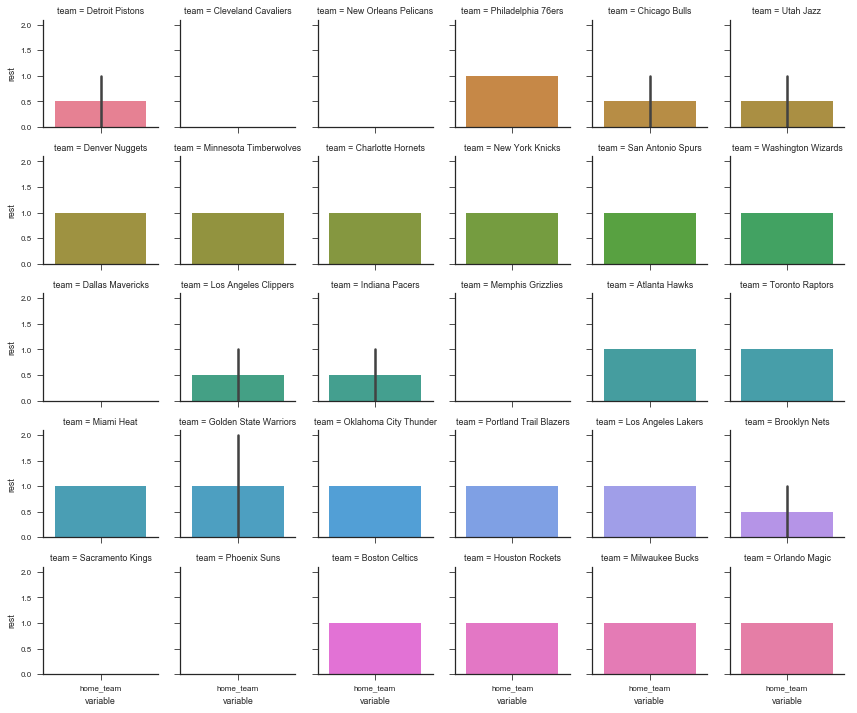

In [10]:
g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team', size=2)
g.map(sns.barplot, 'variable', 'rest');

1. In this code we use seaborns facegrid method. 
2. A FacetGrid can be drawn with up to three dimensions − row, col, and hue. 
3. FacetGrid object takes a dataframe as input and the names of the variables that will form the row, column, or hue dimensions of the grid.
4. The main approach for visualizing data on the above grid is with the FacetGrid.map() method.

In [11]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0,True,-1.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0,False,0.0


1. In this code home win of the teams are calculated by comparing the home points and away points column the result are stored in home_win column which is a boolean.
2. Rest period of teams are calculated by the difference between home rest and away rest columns.
3. The resulting 1st 5 values of dataframe is dispalyed by removing "NaN" values

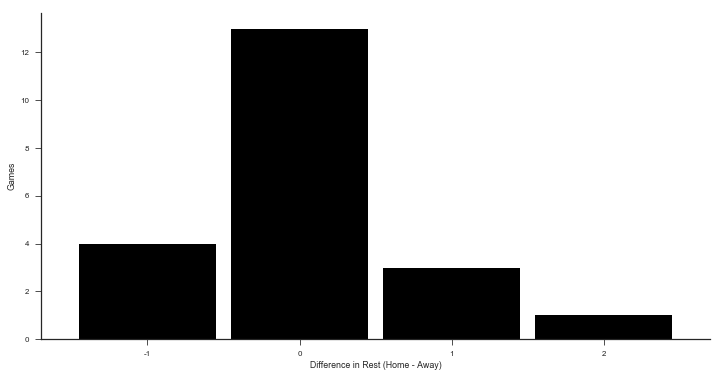

In [12]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games');

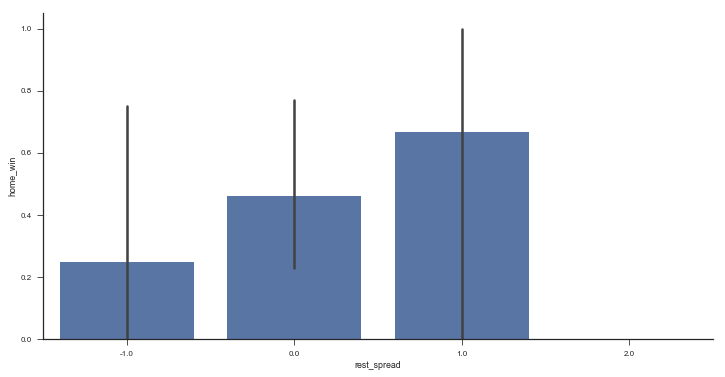

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()

1. Seaborn.barplot= Shows point estimates and confidence intervals as rectangular bars.
2. Seaborn.despine= Remove the top and right spines from plot(s).

# Stack/ UnStack

1. Pandas has two useful methods for quickly converting from wide to long format (stack) and long to wide (unstack).
2. Similar to the pivot function are the .stack() and .unstack() methods. 
3. The process of stacking pivots a level of column labels to the row index. 
4. Unstacking performs the opposite, that is, pivoting a level of the row index into the column index.

In [14]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

In [15]:
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


In the above code we pivoted a level of the row index into the column index. i.e away_team and home_team into column indexes.

In [16]:
rest.unstack().stack() # The inverse of unstack is stack

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
            home_team    0.916667
2015-10-31  away_team    0.166667
            home_team    0.833333
dtype: float64

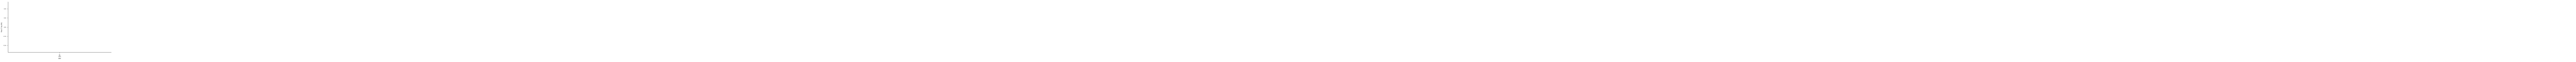

In [18]:
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

ax=(rest.unstack()
        .query('away_team < 7')
        .rolling(7)
        .mean()
        .plot(figsize=(12, 6), linewidth=3, legend=False))
ax.set(ylabel='Rest (7 day MA)')
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()